In [1]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cyclone_obs import *
from cyclone_metrics import *
from my_binned import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [2]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6
fig_dir = '/glade/derecho/scratch/geethma/figures_GFB/'

In [3]:
# --- TOA means
from TOAf import *
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)
common_members = filtered_TOA_15.runs
common_members = common_members[common_members != 175]

In [4]:
# --- maps of the PPE variables I need
var_list = ['dTSmap_gol', 'dLWPmap_gol', 'pe_maps_ol', 'dPE_maps_gol']  # , 'dSWCREmap', 'dLWCREmap', 'wvp_maps_ol', 'w500_maps_ol', 
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

dGMT = lat_weight_mean(var_dict['dTSmap_gol'])[0]  # ∆GMT [K]
pe_maps_ol = var_dict['pe_maps_ol']*86400  # PD P-E [kgm-2day-1]
dLWP_g = var_dict['dLWPmap_gol']/dGMT  # ∆LWP/∆GMT [kgm-2K-1] 
dPE = var_dict['dPE_maps_gol']*86400 /dGMT  # ∆P-E/∆GMT [kgm-2day-1K-1]

dTSmap_gol
dLWPmap_gol
pe_maps_ol
dPE_maps_gol


In [5]:
# all pressure all cloud feedbacks
ds_kernel = {}
for mem_run in common_members:
    pk = 'all_pressure'
    tk = 'all'

    mem = str(mem_run).zfill(3)
    path = (
        f"/glade/derecho/scratch/travisa/CAM6_kernels/"
        f"member_number_{mem}/"
        f"CAM6_PPE_CRK_decomp_{pk}_{tk}_cloud.nc"
    )

    if not os.path.exists(path):
        print(f"Skipping member {mem}: file not found")
        continue

    ds_kernel[mem + pk + tk] = xr.open_dataset(path)

# now for kernel feedback take the global, subtropical, and midltitude means
def trav_fbvar(fbvar, region_dic, ds_kernel=ds_kernel, dGMT=dGMT, common_members=common_members):
    '''return each cloud feedback variable separated into regions.
       fbvar is the feedback component name in strings.'''

    regions = list(region_dic.keys())
    
    SWkernel_regmean = {}
    for reg in (regions):
        SWkernel_list = []
        for mem_run in (common_members):
            mem = str(mem_run).zfill(3)
            SWkernel = ds_kernel[mem+'all_pressure'+'all'][fbvar].mean('time')
            SWkernel_list.append(SWkernel)
    
        SWkernel_all = xr.concat(SWkernel_list,'runs').assign_coords({'runs':common_members})
        SWkernel_regmean[reg] = SWkernel_all.load()/dGMT
    return SWkernel_regmean

# cloud feedback components
region_dic = {
    'global' : [0, 90]
}
LWcld_tot_fb_global = trav_fbvar('LWcld_tot', region_dic)
SWcld_tot_fb_global = trav_fbvar('SWcld_tot', region_dic)
LWcld_tot_fb_global = LWcld_tot_fb_global['global'].sel(runs=common_members)
SWcld_tot_fb_global = SWcld_tot_fb_global['global'].sel(runs=common_members)
totdCRE_g = LWcld_tot_fb_global + SWcld_tot_fb_global


In [6]:
print(np.array_equal(
    totdCRE_g.runs,
    dPE.runs
))


True


In [7]:
# --- cyclone EC observations
from cyclone_obs import *
obs_dict = cyclone_obs()

cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']/3600.  #[mm/s]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

obs_grad_LWP_PRC = 1/obs_grad

ecpe_uncertainty = np.sqrt(0.10**2 + 0.35**2 + 0.27**2)  # updated to include the sampling uncertainty
lower_bound_PRC = obs_grad_LWP_PRC - ecpe_uncertainty * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + ecpe_uncertainty * obs_grad_LWP_PRC

obs_pe_metric = obs_grad_LWP_PRC  # observational EC precipitation efficiency
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  # upper and lower bounds with uncertainty
print(f'obs_grad_LWP_PRC = {obs_grad_LWP_PRC} +/- {ecpe_uncertainty * obs_grad_LWP_PRC}')

obs_grad_LWP_PRC = 0.0014278375841849642 +/- 0.0006471113677436142


In [8]:
# --- ecpe metric
_, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = 1./(PPE_grad_LWP_PRC.sel(runs=common_members)*86400.)  # [s-1]
# PPE_grad_LWP_WCB = 1/(PPE_grad_LWP_WCB.sel(runs=common_members))

In [21]:
def pos_correlation(
    give_var, give_var_nm,
    color_by, color_by_nm,
    totcld_tau_amt, totcld_tau_amt_nm
):
    # --------------------------------------------------
    # 1) Build mask: positive & finite give_var
    # --------------------------------------------------

    # Make give_var into an xarray aligned to totcld_tau_amt
    if not isinstance(give_var, xr.DataArray):
        give_var = xr.DataArray(
            give_var,
            dims=totcld_tau_amt.dims,
            coords=totcld_tau_amt.coords
        )
    else:
        give_var = give_var.assign_coords({
            'lat': totcld_tau_amt.lat,
            'lon': totcld_tau_amt.lon
        })

    mask_pos = (give_var > 0) & np.isfinite(give_var)

    # Broadcast mask to match totcld_tau_amt dims
    mask = mask_pos.broadcast_like(totcld_tau_amt)

    give_var_xr = give_var.where(mask)
    give_var_xr.name = give_var_nm
    plt.figure(); give_var_xr[0].plot(cmap='plasma')

    # --------------------------------------------------
    # Mask cloud feedback
    # --------------------------------------------------
    totcld_tau_amt_g_xr = totcld_tau_amt.where(mask)
    totcld_tau_amt_g_xr.name = totcld_tau_amt_nm
    plt.figure(); totcld_tau_amt_g_xr[0].plot(cmap='plasma')

    # --------------------------------------------------
    # Prepare & mask color_by (1D / 2D / 3D)
    # --------------------------------------------------
    color_by = np.asarray(color_by)

    if color_by.ndim == 1:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs',),
            coords={'runs': totcld_tau_amt.runs}
        ).broadcast_like(totcld_tau_amt)

    elif color_by.ndim == 2:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('lat', 'lon'),
            coords={
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        ).broadcast_like(totcld_tau_amt)

    elif color_by.ndim == 3:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs', 'lat', 'lon'),
            coords={
                'runs': totcld_tau_amt.runs,
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        )

    else:
        raise ValueError("color_by must be 1D, 2D, or 3D")

    # Apply the SAME mask
    dLWP_g_xr = color_by_xr.where(mask)
    dLWP_g_xr.name = color_by_nm
    plt.figure(); dLWP_g_xr[0].plot(cmap='plasma')

    # --------------------------------------------------
    # 4) Latitude-weighted means
    # --------------------------------------------------
    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
    cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

    # --------------------------------------------------
    # 5) Scatter plot
    # --------------------------------------------------
    X_scatter = PPE_grad_LWP_PRC.data
    Y_scatter = cf_mean.data

    plt.figure()
    scatter = plt.scatter(
        X_scatter, Y_scatter,
        c=dLWP_TSmap_sel_mean,
        cmap='plasma'
    )

    plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    plt.axvspan(lower_pe_metric, upper_pe_metric, color='grey', alpha=0.3)

    # Binned correlation
    y_bin, x_bin, _, count = my_binned(
        X_scatter, Y_scatter, num_bins=10, percentiles=True
    )
    c_ind = count > 10
    corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])

    plt.plot(
        x_bin[c_ind], y_bin[c_ind],
        'grey', label=f'Spearman (binned): {corr:.3f}'
    )

    plt.xlabel(r'$∂P/∂LWP_{EC}\ [s^{-1}]$')
    plt.ylabel(totcld_tau_amt_nm)
    plt.title(f'Positive {give_var_nm}')
    plt.legend()

    cb = plt.colorbar(scatter)
    cb.set_label(color_by_nm)

    # --------------------------------------------------
    # 6) Constrained runs
    # --------------------------------------------------
    mask_cons = (
        (PPE_grad_LWP_PRC >= lower_pe_metric) &
        (PPE_grad_LWP_PRC <= upper_pe_metric)
    )

    PPE_constrained = PPE_grad_LWP_PRC.where(mask_cons, drop=True)

    constrained_positive = cf_mean.where(
        cf_mean['runs'].isin(PPE_constrained['runs']),
        drop=True
    )

    plt.scatter(
        PPE_constrained,
        constrained_positive,
        facecolors='none',
        edgecolors='black'
    )

    plt.xscale('log')

    plt.savefig(
        f'{fig_dir}lamcld_ecpe_{color_by_nm}_inPOS{give_var_nm}.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=600
    )

    return constrained_positive, cf_mean


In [22]:
def neg_correlation(
    give_var, give_var_nm,
    color_by, color_by_nm,
    totcld_tau_amt, totcld_tau_amt_nm
):
    # --------------------------------------------------
    # 1) Build mask: positive & finite give_var
    # --------------------------------------------------

    # Make give_var into an xarray aligned to totcld_tau_amt
    if not isinstance(give_var, xr.DataArray):
        give_var = xr.DataArray(
            give_var,
            dims=totcld_tau_amt.dims,
            coords=totcld_tau_amt.coords
        )
    else:
        give_var = give_var.assign_coords({
            'lat': totcld_tau_amt.lat,
            'lon': totcld_tau_amt.lon
        })

    mask_pos = (give_var < 0) & np.isfinite(give_var)

    # Broadcast mask to match totcld_tau_amt dims
    mask = mask_pos.broadcast_like(totcld_tau_amt)

    give_var_xr = give_var.where(mask)
    give_var_xr.name = give_var_nm
    plt.figure(); give_var_xr[0].plot(cmap='plasma')

    # --------------------------------------------------
    # Mask cloud feedback
    # --------------------------------------------------
    totcld_tau_amt_g_xr = totcld_tau_amt.where(mask)
    totcld_tau_amt_g_xr.name = totcld_tau_amt_nm
    plt.figure(); totcld_tau_amt_g_xr[0].plot(cmap='plasma')

    # --------------------------------------------------
    # Prepare & mask color_by (1D / 2D / 3D)
    # --------------------------------------------------
    color_by = np.asarray(color_by)

    if color_by.ndim == 1:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs',),
            coords={'runs': totcld_tau_amt.runs}
        ).broadcast_like(totcld_tau_amt)

    elif color_by.ndim == 2:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('lat', 'lon'),
            coords={
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        ).broadcast_like(totcld_tau_amt)

    elif color_by.ndim == 3:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs', 'lat', 'lon'),
            coords={
                'runs': totcld_tau_amt.runs,
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        )

    else:
        raise ValueError("color_by must be 1D, 2D, or 3D")

    # Apply the SAME mask
    dLWP_g_xr = color_by_xr.where(mask)
    dLWP_g_xr.name = color_by_nm
    plt.figure(); dLWP_g_xr[0].plot(cmap='plasma')

    # --------------------------------------------------
    # 4) Latitude-weighted means
    # --------------------------------------------------
    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
    cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

    # --------------------------------------------------
    # 5) Scatter plot
    # --------------------------------------------------
    X_scatter = PPE_grad_LWP_PRC.data
    Y_scatter = cf_mean.data

    plt.figure()
    scatter = plt.scatter(
        X_scatter, Y_scatter,
        c=dLWP_TSmap_sel_mean,
        cmap='plasma'
    )

    plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    plt.axvspan(lower_pe_metric, upper_pe_metric, color='grey', alpha=0.3)

    # Binned correlation
    y_bin, x_bin, _, count = my_binned(
        X_scatter, Y_scatter, num_bins=10, percentiles=True
    )
    c_ind = count > 10
    corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])

    plt.plot(
        x_bin[c_ind], y_bin[c_ind],
        'grey', label=f'Spearman (binned): {corr:.3f}'
    )

    plt.xlabel(r'$∂P/∂LWP_{EC}\ [s^{-1}]$')
    plt.ylabel(totcld_tau_amt_nm)
    plt.title(f'Positive {give_var_nm}')
    plt.legend()

    cb = plt.colorbar(scatter)
    cb.set_label(color_by_nm)

    # --------------------------------------------------
    # 6) Constrained runs
    # --------------------------------------------------
    mask_cons = (
        (PPE_grad_LWP_PRC >= lower_pe_metric) &
        (PPE_grad_LWP_PRC <= upper_pe_metric)
    )

    PPE_constrained = PPE_grad_LWP_PRC.where(mask_cons, drop=True)

    constrained_positive = cf_mean.where(
        cf_mean['runs'].isin(PPE_constrained['runs']),
        drop=True
    )

    plt.scatter(
        PPE_constrained,
        constrained_positive,
        facecolors='none',
        edgecolors='black'
    )

    plt.xscale('log')

    plt.savefig(
        f'{fig_dir}lamcld_ecpe_{color_by_nm}_inPOS{give_var_nm}.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=600
    )

    return constrained_positive, cf_mean


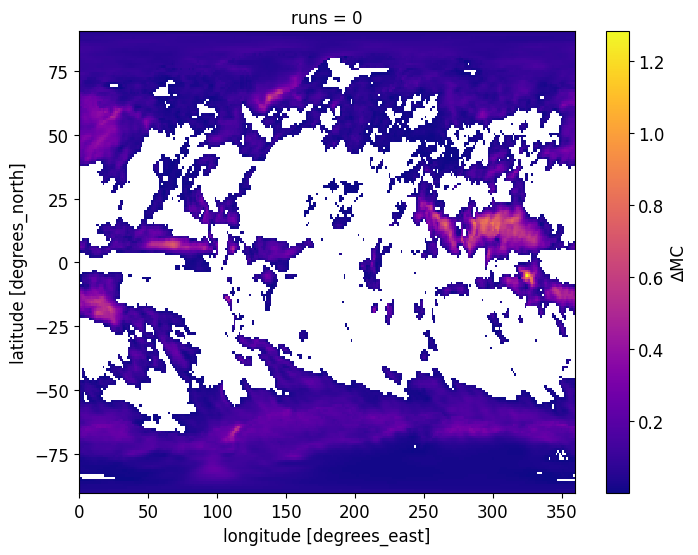

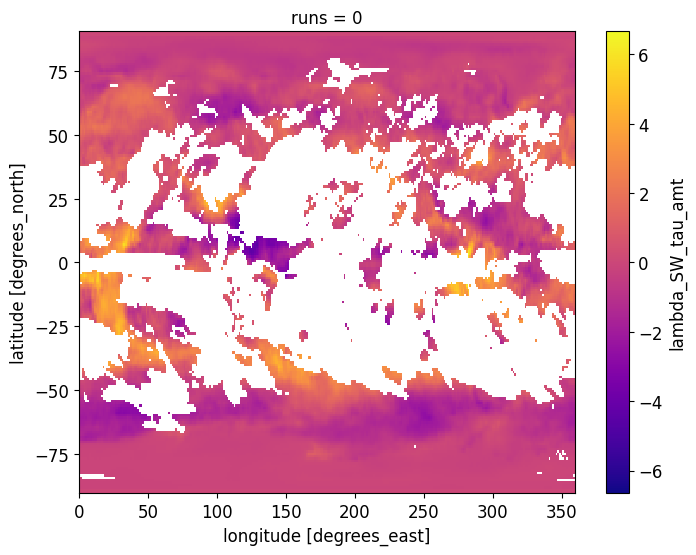

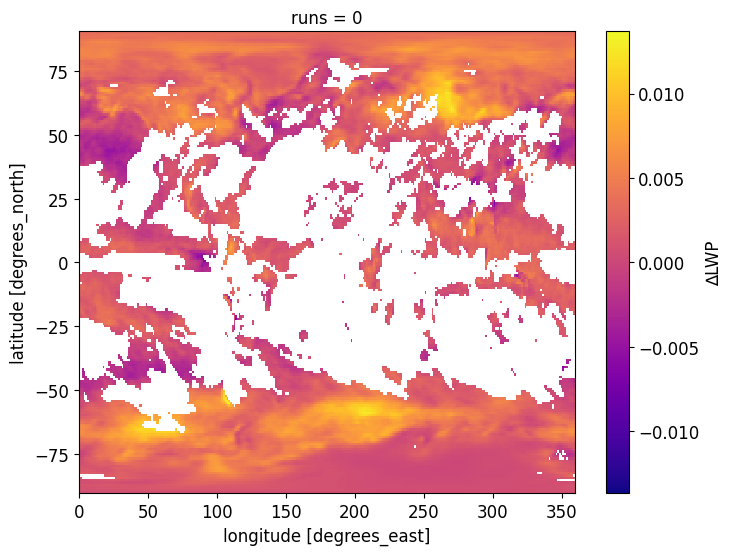

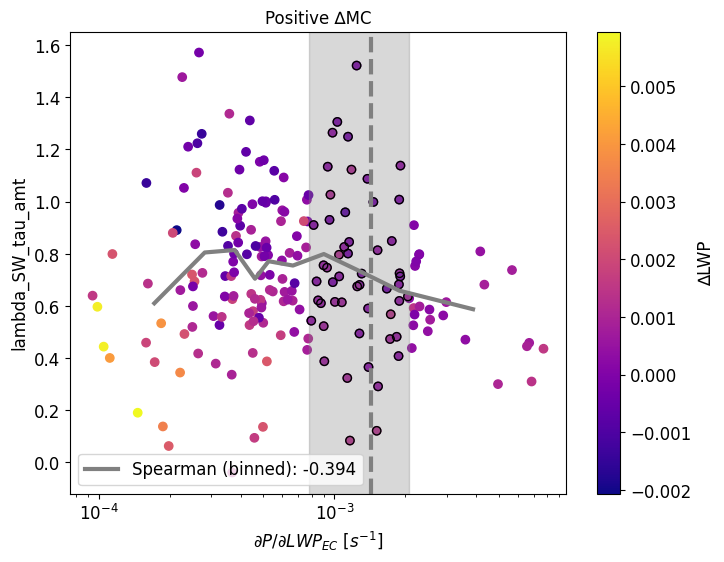

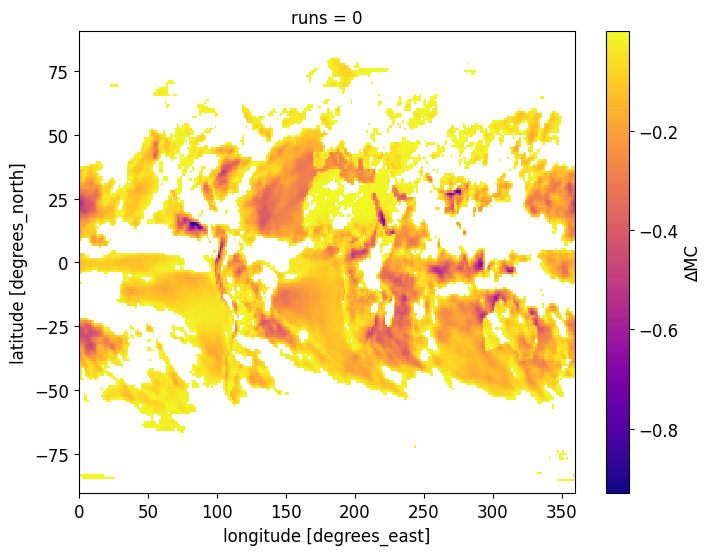

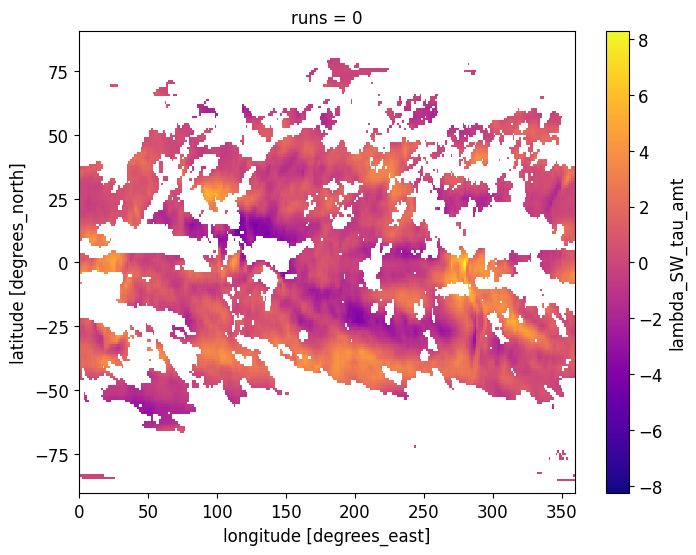

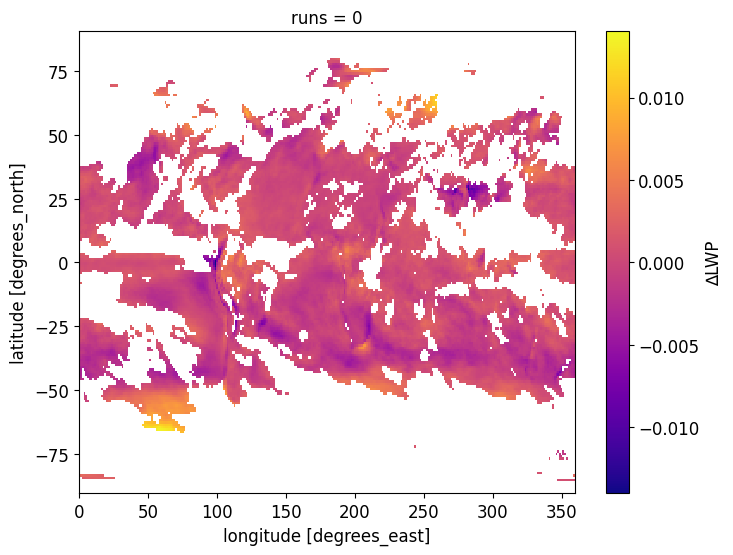

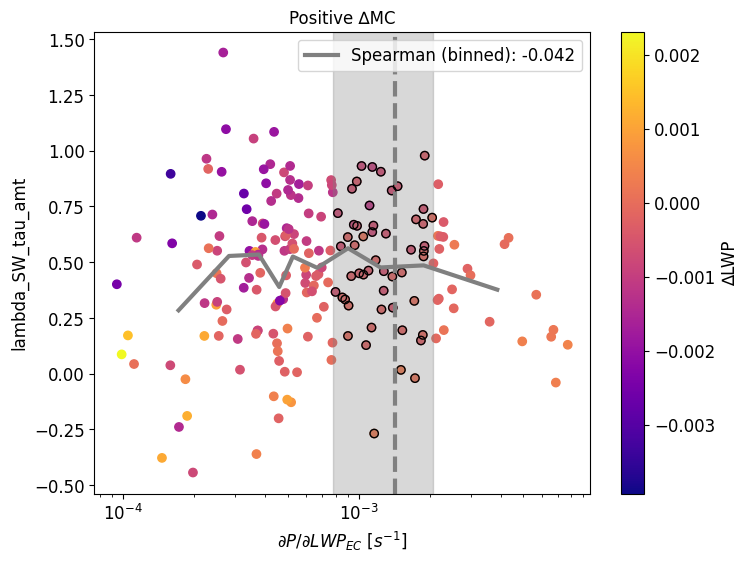

In [23]:
give_var, give_var_nm = [dPE, '∆MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global'] + trav_fbvar('SWcld_amt', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt, 'lambda_SW_tau_amt']

constrained_positive, cf_mean_positive = pos_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm
)

constrained_negative, cf_mean_negative = neg_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm
)

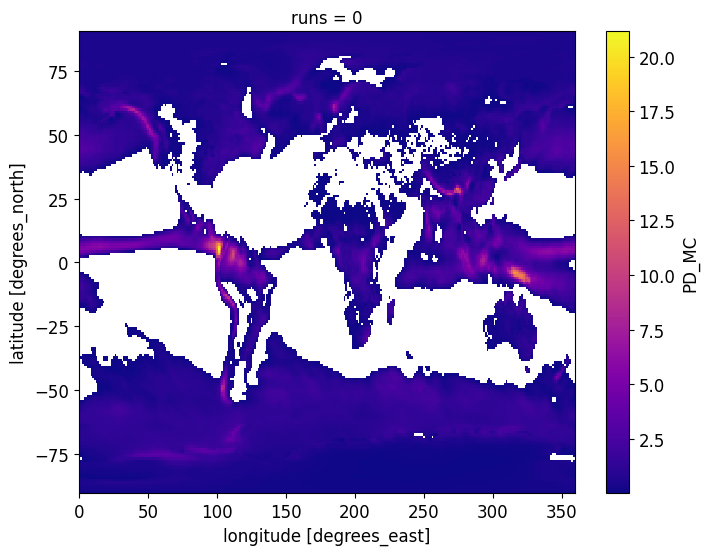

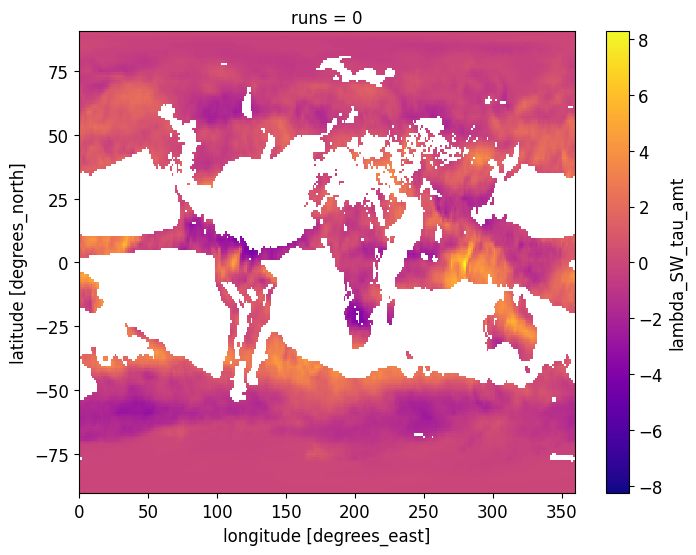

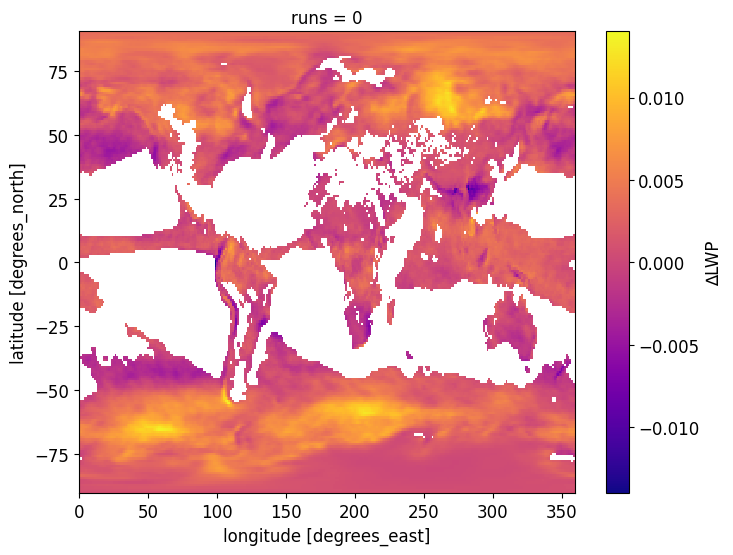

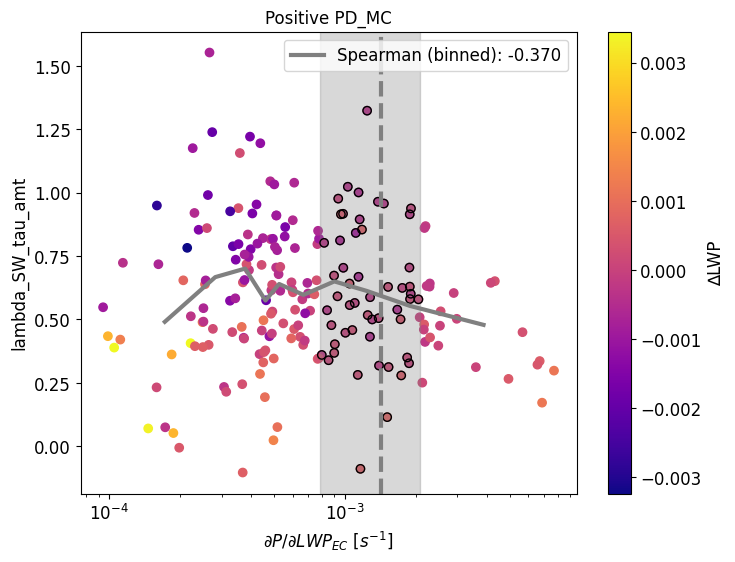

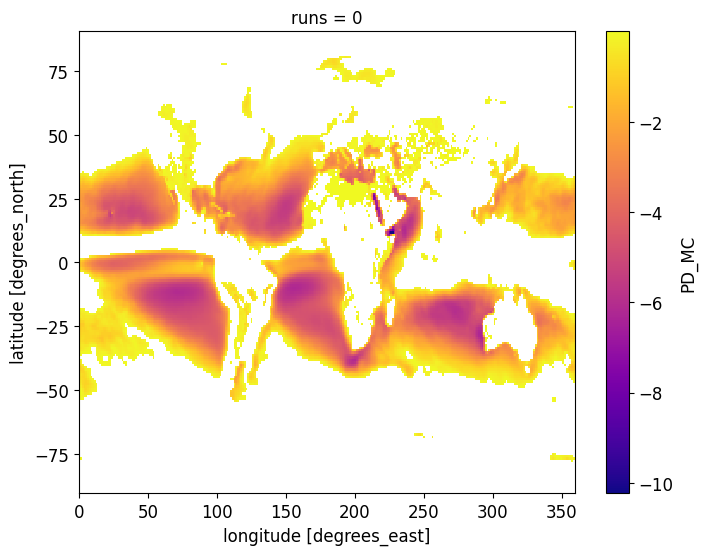

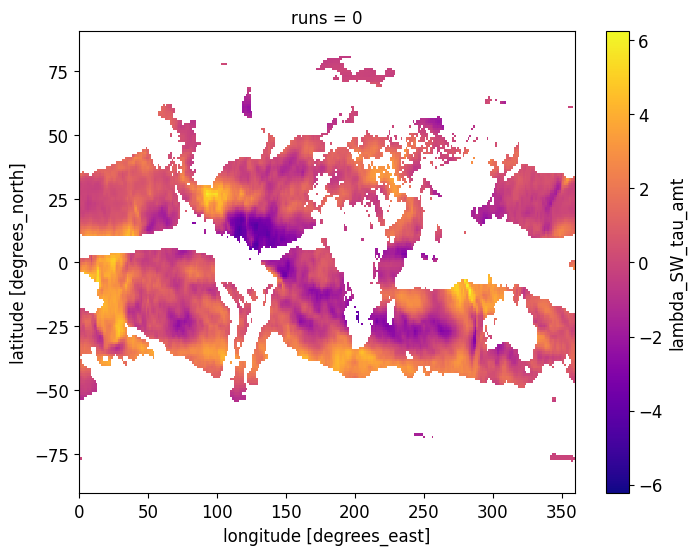

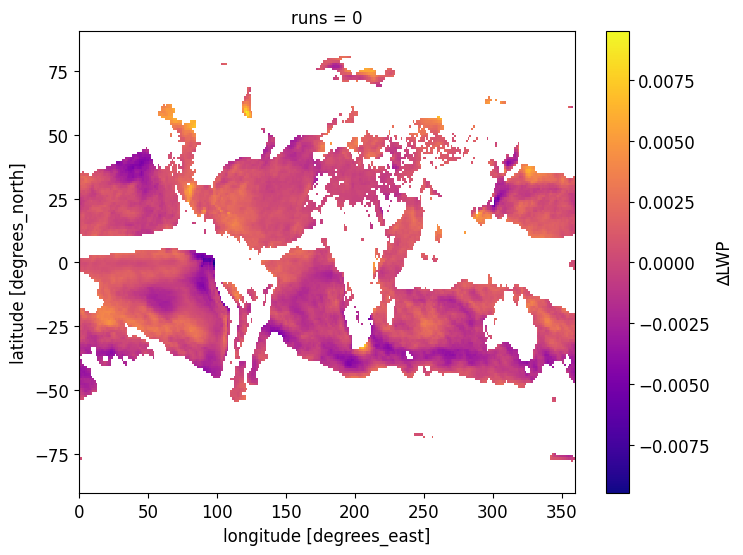

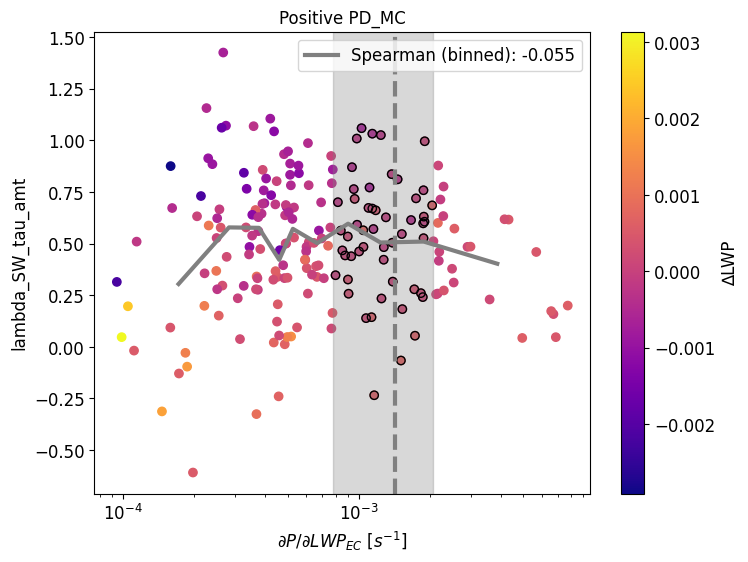

In [24]:
give_var, give_var_nm = [pe_maps_ol, 'PD_MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global'] + trav_fbvar('SWcld_amt', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt, 'lambda_SW_tau_amt']

constrained_positive, cf_mean_positive = pos_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm
)

constrained_negative, cf_mean_negative = neg_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm
)